# 1. Perkenalan Dataset





#### 1.1 Deskripsi Dataset

- Sumber Data: Kaggle - https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment
- Jumlah Data: 5000 sampel
- Fitur Numerik:
Temperature, Humidity, PM2.5, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
- Fitur Kategorikal:
Air Quality (Target)

# 2. Import Library

In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import RFE

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# 3. Memuat Dataset

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('updated_pollution_dataset.csv')

Saving updated_pollution_dataset.csv to updated_pollution_dataset.csv


# 4. Exploratory Data Analysis (EDA)


#### 4.1 Deskripsi Variabel

In [3]:
# Statistical description
df.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,69.810180,20.142140,30.218400,26.412100,10.020720,1.500354,8.425400,497.423800
std,6.720661,15.301732,24.554546,27.349155,8.895356,6.740247,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,0.000000,7.400000,0.000000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,100.000000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


Insight:
1. Deskripsi singkat masing-masing fitur:
  - Temperature (°C)
→ Suhu lingkungan sekitar saat pengukuran.
Insight: Suhu dapat memengaruhi dispersi polutan; misalnya, suhu tinggi bisa meningkatkan pembentukan ozon.
  - Humidity (%)
→ Kelembapan udara saat pengukuran.
Insight: Kelembapan tinggi bisa menahan partikel di udara, meningkatkan konsentrasi PM2.5 dan PM10.
  - PM2.5 (µg/m³)
→ Partikulat halus berdiameter ≤ 2.5 mikrometer.
Insight: Dapat menembus paru-paru, sangat berbahaya bagi kesehatan, sering menjadi indikator utama kualitas udara buruk.
  - PM10 (µg/m³)
→ Partikulat kasar berdiameter ≤ 10 mikrometer.
Insight: Sumbernya bisa dari debu jalan, konstruksi, dan aktivitas industri. Bisa memperburuk kondisi pernapasan.
  - NO2 (ppb)
→ Nitrogen dioksida, indikator polusi dari kendaraan dan pembakaran bahan bakar.
Insight: Paparan tinggi berkaitan dengan masalah paru-paru dan iritasi saluran pernapasan.
  - SO2 (ppb)
→ Sulfur dioksida, umumnya dari pembakaran batu bara dan industri.
Insight: Berpotensi menyebabkan iritasi dan memperburuk penyakit pernapasan.
  - CO (ppm)
→ Karbon monoksida, biasanya dari emisi kendaraan dan pembakaran tidak sempurna.
Insight: Dalam konsentrasi tinggi, sangat beracun dan mengganggu distribusi oksigen dalam tubuh.
  - Proximity_to_Industrial_Areas (km)
→ Jarak lokasi ke kawasan industri terdekat.
Insight: Semakin dekat ke industri, potensi terpapar polusi udara biasanya lebih tinggi.
  - Population_Density (orang/km²)
→ Kepadatan penduduk di area tersebut.
Insight: Daerah padat penduduk cenderung punya aktivitas manusia lebih tinggi, yang bisa memperburuk kualitas udara (misalnya dari kendaraan dan rumah tangga).
2. Ada beberapa nilai tidak wajar (Anomali)
  - PM10 (min = -0.2)	Nilai negatif (tidak mungkin)	kemungkinan disebabkan kesalahan sensor/data entry. Solusi: Replace dengan 0 atau hapus baris.
  - SO2 (min = -6.2)	Nilai negatif (tidak realistis)	kemungkinan kesalahan pengukuran. Solusi: Clipping ke nilai minimum fisik (misal: 0).
  - PM2.5 (max = 295)	Nilai ekstrem (outlier)	kemungkinan akibat polusi berat akibat industri,kebakaran hutan atau noise data. Solusi: Pertahankan data
  - Humidity (max = 128.1%)	Kelembapan >100% (tidak mungkin)	kemungkinan kesalahan kalibrasi sensor. Solusi: Cap nilai maksimum 100%.


#### 4.2 Univariate Analysis

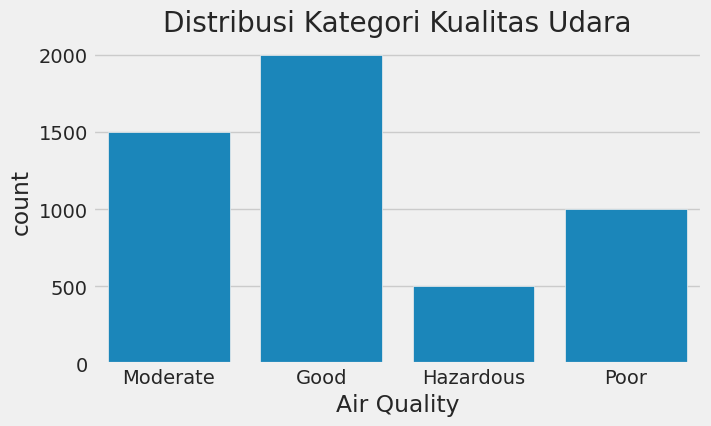

In [4]:
# Visualisasi distribusi target
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Air Quality')
plt.title('Distribusi Kategori Kualitas Udara')
plt.show()

Insight:
- Distribusi fitur kategori kualitas udara menunjukkan ketidakseimbangan kelas (class imbalance) dengan rasio 4:3:2:1.
- Solusi: Tambahkan class_weight='balanced' saat training model.



#### 4.3 Multivariate Analysis

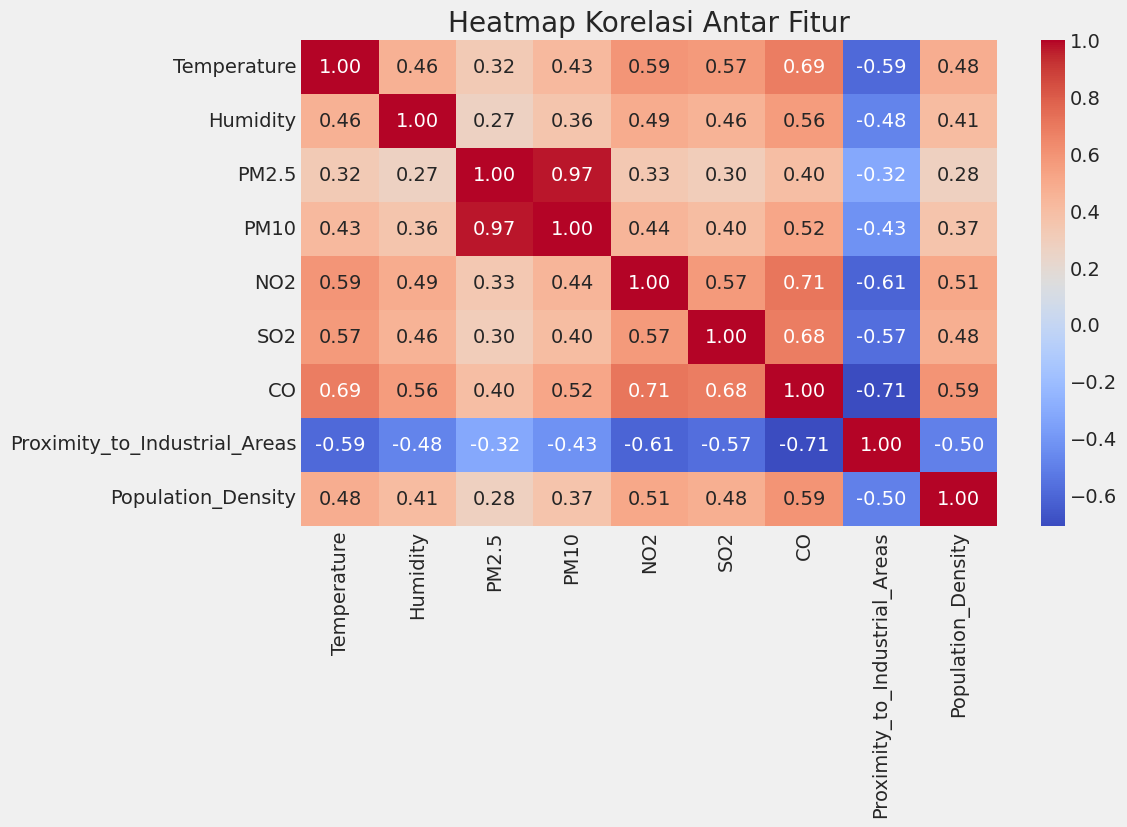

In [5]:
# Visualisasi korelasi antar fitur numerik
plt.figure(figsize=(10,6))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

In [6]:
# Hitung matriks korelasi
corr = df.select_dtypes(include=np.number).corr()

# Mencetak matriks korelasi
corr

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
Temperature,1.000000,0.462013,0.323840,0.425689,0.591969,0.569083,0.685258,-0.589564,0.481692
Humidity,0.462013,1.000000,0.269793,0.355299,0.488211,0.456215,0.563114,-0.481102,0.407358
PM2.5,0.323840,0.269793,1.000000,0.973005,0.333004,0.300194,0.395179,-0.315766,0.278957
PM10,0.425689,0.355299,0.973005,1.000000,0.439917,0.402733,0.518894,-0.425018,0.365735
NO2,0.591969,0.488211,0.333004,0.439917,1.000000,0.572656,0.710792,-0.607710,0.510938
SO2,0.569083,0.456215,0.300194,0.402733,0.572656,1.000000,0.680515,-0.571458,0.475999
CO,0.685258,0.563114,0.395179,0.518894,0.710792,0.680515,1.000000,-0.707581,0.593389
Proximity_to_Industrial_Areas,-0.589564,-0.481102,-0.315766,-0.425018,-0.607710,-0.571458,-0.707581,1.000000,-0.498058
Population_Density,0.481692,0.407358,0.278957,0.365735,0.510938,0.475999,0.593389,-0.498058,1.000000


Insight:

- Korelasi Tinggi antara PM2.5 dan PM10 (0.973)
Artinya kedua variabel ini sangat mirip dan membawa informasi yang hampir sama. Bisa dipertimbangkan untuk membuang salah satunya, tetapi karena kita menggunakan model Random Forest dan XGBoost maka keduanya akan dipertahankan dengan asumsi bahwa model akan memilih satu fitur terbaik untuk split di setiap node.

- CO punya korelasi tinggi dengan banyak fitur lain, termasuk: NO2 (0.71),
  Temperature (0.69), SO2 (0.68) dan Population Density (0.59)
  → Tapi CO tetap penting karena termasuk top polutan dalam klasifikasi kualitas udara.

- Proximity_to_Industrial_Areas punya korelasi negatif kuat dengan CO (-0.71) dan polutan lainnya
→ Artinya masuk akal secara domain knowledge: makin dekat ke industri, makin tinggi polutan.

- Tidak ada fitur dengan korelasi sangat rendah (mendekati 0) terhadap semua fitur lain — ini berarti semua fitur cukup informatif dalam hubungannya dengan fitur lain.



# 5. DATA PREPROCESSING

### 5.1 Menangani Missing Value

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


Insight:

Tidak ada missing values dalam dataset

### 5.2 Menangani Outliers

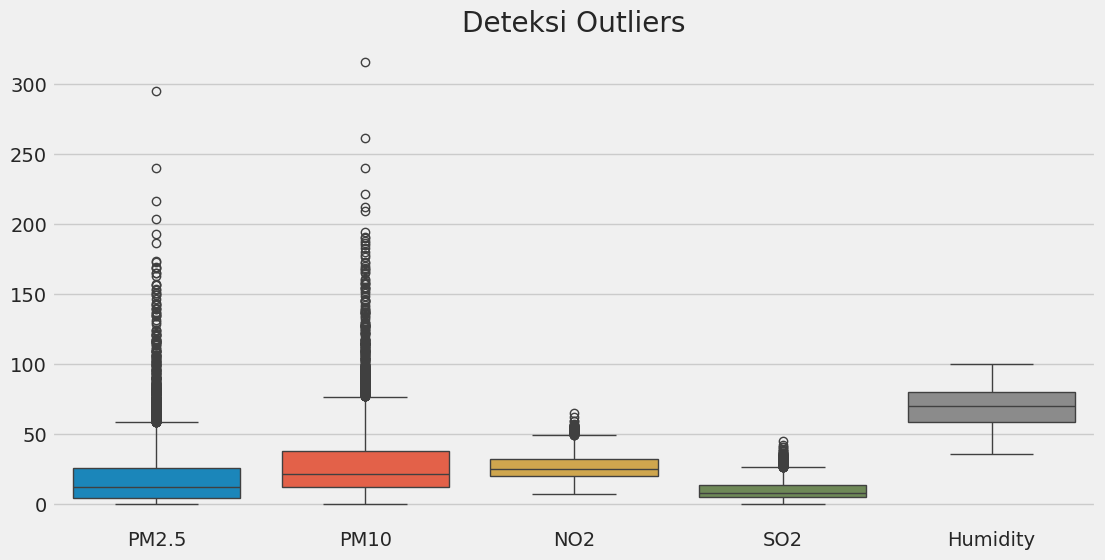

In [8]:
# Visualisasi boxplot untuk deteksi outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['PM2.5', 'PM10', 'NO2', 'SO2', 'Humidity']])
plt.title("Deteksi Outliers")
plt.show()

In [9]:
# Calculate outliers
def count_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Humidity']
for pollutant in pollutants:
    outliers = count_outliers(df[pollutant])
    jumlah_outlier = len(outliers)
    persentase_outlier = (jumlah_outlier / len(df[pollutant])) * 100
    print(f"Polutan: {pollutant}")
    print(f"Jumlah Outlier: {jumlah_outlier}")
    print(f"Persentase Outlier: {persentase_outlier:.2f}%")
    print("-" * 20)

Polutan: PM2.5
Jumlah Outlier: 352
Persentase Outlier: 7.04%
--------------------
Polutan: PM10
Jumlah Outlier: 324
Persentase Outlier: 6.48%
--------------------
Polutan: NO2
Jumlah Outlier: 73
Persentase Outlier: 1.46%
--------------------
Polutan: SO2
Jumlah Outlier: 124
Persentase Outlier: 2.48%
--------------------
Polutan: Humidity
Jumlah Outlier: 0
Persentase Outlier: 0.00%
--------------------


Outlier positif pada PM2.5, PM10, NO2 dan SO2 akan dipertahankan untuk mendeksripsikan kondisi sebenarnya seperti emisi industri dan kebakaran hutan. Namun untuk nilai yang dianggap tidak valid akan ditangani dengan dengan caping/clipping.

In [10]:
# Clipping PM10 ke Nilai Minimum Fisik (0)
# Mengganti semua nilai PM10 yang negatif dengan 0
df['PM10'] = df['PM10'].clip(lower=0)

# Verifikasi
print("Nilai minimum PM10 setelah clipping:", df['PM10'].min())

Nilai minimum PM10 setelah clipping: 0.0


In [11]:
# Clipping SO2 ke Nilai Minimum Fisik (0)
# Mengganti semua nilai SO2 yang negatif dengan 0
df['SO2'] = df['SO2'].clip(lower=0)

# Verifikasi
print("Nilai minimum SO2 setelah clipping:", df['SO2'].min())

Nilai minimum SO2 setelah clipping: 0.0


In [12]:
# Capping Humidity Maksimum 100%
# Mengganti semua nilai Humidity >100% dengan 100
df['Humidity'] = df['Humidity'].clip(upper=100)

# Verifikasi
print("Nilai maksimum Humidity setelah capping:", df['Humidity'].max())

Nilai maksimum Humidity setelah capping: 100.0


### 5.3 Encoding Variabel Target

In [13]:
# Pisahkan fitur dan target
X = df.drop('Air Quality', axis=1)
y = df['Air Quality']

In [14]:
# Encoding target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### 5.4 Data Splitting

In [15]:
# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

Jumlah data training: 4000
Jumlah data testing: 1000


### 5.5 Feature Scaling

In [16]:
# Inisialisasi scaler
scaler = StandardScaler()

# Fit dan transform hanya pada train set
X_train_scaled = scaler.fit_transform(X_train)

# Transform test set dengan parameter yang sama
X_test_scaled = scaler.transform(X_test)